## QUANTUM AUTOENCODER ##

In [1]:
import time
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import csv
from pennylane import numpy

/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def ansatz(init_weights, weights):
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires_latent+n_wires_trash))

In [3]:
def swap_test(num_latent, num_trash):
    auxiliary_qubit = num_latent + 2 * num_trash
    qml.Hadamard(auxiliary_qubit)
    for i in range(num_trash):
        qml.CSWAP(wires=[auxiliary_qubit, num_latent + i, num_latent + num_trash + i])
    qml.Hadamard(auxiliary_qubit)

In [4]:
n_wires_latent = 3
n_wires_trash = 2
n_wires_total = n_wires_latent + 2 * n_wires_trash +1

In [5]:
dev = qml.device("default.qubit", wires=n_wires_total)

In [6]:
def quantum_encoder_train(init_weights, weights, n_wires_latent, n_wires_trash):
    ansatz(init_weights, weights)
    swap_test(n_wires_latent, n_wires_trash)

In [7]:
@qml.qnode(dev)
def domain_wall(params):
    # Separare i parametri
    init_weights = params[:5]
    init_weights = qml.numpy.tensor(init_weights, requires_grad=True)
    weights = params[5:]
    weights = np.reshape(weights, (2, 4, 2))
    weights = qml.numpy.tensor(weights, requires_grad=True)
    qml.X(2)
    qml.X(3)
    qml.X(4)
    quantum_encoder_train(init_weights, weights, n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)#, op=qml.PauliZ(7))
    #return qml.expval(qml.Z(7))

In [8]:
initial_point = np.random.random((5,))
print(np.shape(initial_point))
initial_point = qml.numpy.tensor(initial_point, requires_grad=True)
weights = np.random.random((2, 4, 2))
weights = qml.numpy.tensor(weights, requires_grad=True)
print(np.shape(weights))
print(weights)
params = np.concatenate([initial_point, weights.flatten()])
params = qml.numpy.tensor(params, requires_grad=True)
print(params)
print(params[:5])

(5,)
(2, 4, 2)
[[[0.82360744 0.36101362]
  [0.07645424 0.73787357]
  [0.17014722 0.37939485]
  [0.21997007 0.29912964]]

 [[0.62394234 0.70675289]
  [0.6497985  0.51042598]
  [0.62982895 0.54037483]
  [0.42948393 0.81551319]]]
[0.43128185 0.74242862 0.5647913  0.25267334 0.39348637 0.82360744
 0.36101362 0.07645424 0.73787357 0.17014722 0.37939485 0.21997007
 0.29912964 0.62394234 0.70675289 0.6497985  0.51042598 0.62982895
 0.54037483 0.42948393 0.81551319]
[0.43128185 0.74242862 0.5647913  0.25267334 0.39348637]


(<Figure size 800x900 with 1 Axes>, <Axes: >)


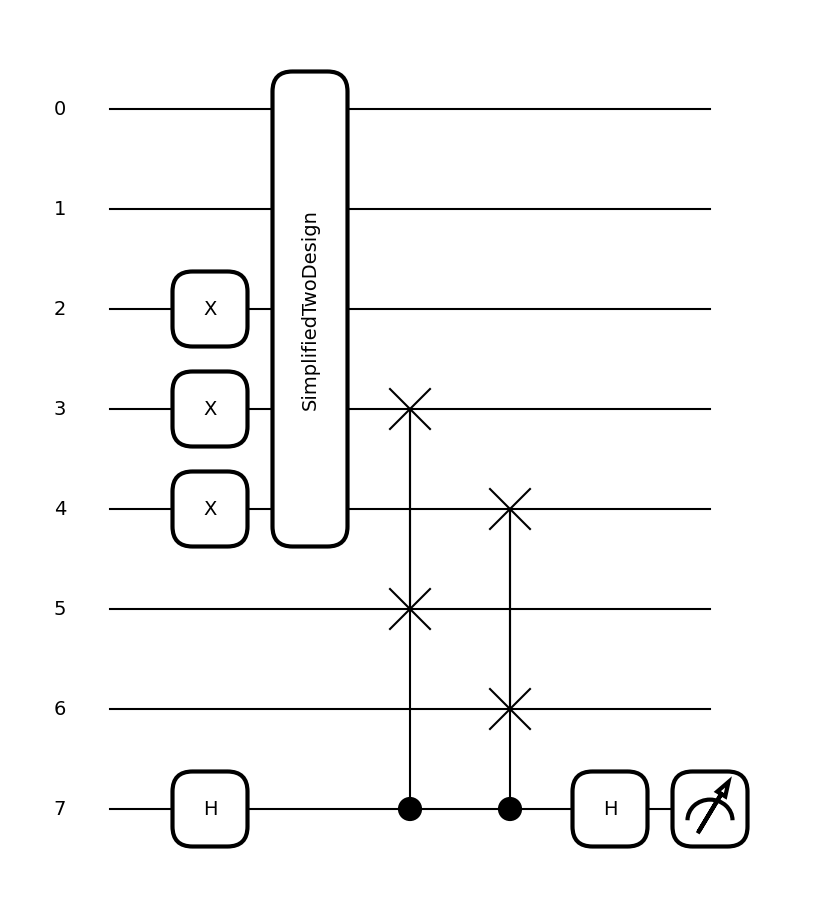

In [9]:
drawer = qml.draw_mpl(domain_wall)
print(drawer(params))

In [10]:
# Definizione della funzione di costo come la somma delle probabilità di misurare 1
def cost_function(params):
    
    # Ottiene le probabilità di misurazione
    probs = domain_wall(params)
    print(f"Probabilities: {probs}")
    
    # La funzione di costo è la somma delle probabilità di ottenere 1
    cost = probs[1]  # Assumendo che prob[1] rappresenti la probabilità di misurare 1
    print(f"Probability of measuring 1: {cost}")
    return cost


In [15]:
# Inizializzazione dell'ottimizzatore
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 150
costs = []

# Ciclo di addestramento
start = time.time()
for i in range(steps):
    params, cost_val = opt.step_and_cost(cost_function, params)
    costs.append(cost_val)
    if i%5==0:
        print(f"Step {i+1}: cost = {cost_val:.4f}")

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")
# Stampa dei pesi ottimizzati
print("Pesi ottimizzati:", params)
opt_weights = params

Probabilities: Autograd ArrayBox with value [0.5092523 0.4907477]
Probability of measuring 1: Autograd ArrayBox with value 0.49074769723153844
Step 1: cost = 0.4907
Probabilities: Autograd ArrayBox with value [0.50975336 0.49024664]
Probability of measuring 1: Autograd ArrayBox with value 0.49024663984021183
Probabilities: Autograd ArrayBox with value [0.5102909 0.4897091]
Probability of measuring 1: Autograd ArrayBox with value 0.4897091018548564
Probabilities: Autograd ArrayBox with value [0.51086779 0.48913221]
Probability of measuring 1: Autograd ArrayBox with value 0.4891322083257238
Probabilities: Autograd ArrayBox with value [0.51148716 0.48851284]
Probability of measuring 1: Autograd ArrayBox with value 0.4885128436594138
Probabilities: Autograd ArrayBox with value [0.51215237 0.48784763]
Probability of measuring 1: Autograd ArrayBox with value 0.4878476304274459
Step 6: cost = 0.4878
Probabilities: Autograd ArrayBox with value [0.51286709 0.48713291]
Probability of measuring 1

In [16]:
print(opt_weights)

[ 0.44205247  0.63498707  0.32621256 -0.4872351   0.3019095   0.82360744
  0.25815084  0.25336074  1.60684445  0.17014722  0.19459961 -0.18497642
  1.30845233  0.62394234  0.70675289  0.6497985   0.84944136  0.62982895
  0.54037483 -0.24803566  1.67074886]


In [17]:
# Salva i pesi ottimizzati in un file CSV
with open("optimized_weights.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in weights])


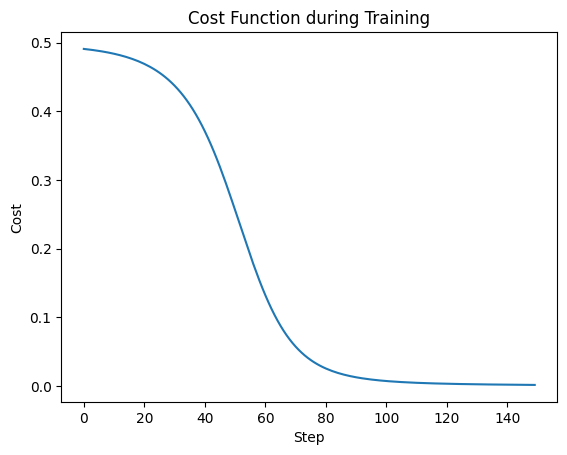

In [18]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(costs)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [19]:
dev_autoencoder = qml.device("default.qubit", wires=n_wires_latent+n_wires_trash)

In [ ]:
def reset_to_zero():
    # Prepara il qubit 0 in uno stato casuale (qui usiamo X per mettere il qubit in |1>)
    # Misura lo stato del qubit
    m = qml.measure(wires=4)
    m = qml.measure(wires=5)

    # Condizionale per resettare il qubit a |0>
    qml.cond(m, qml.PauliX)(wires=0)
    print()

In [ ]:
@qml.qnode(dev_autoencoder)
def autoencoder(opt_weights):   
    domain_wall(opt_weights)
    